In [20]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
# ensure that any edits to libraries you make are reloaded here automatically,
# and also that any charts or images displayed are shown in this notebook.


import numpy as np
import scipy as sc
import sklearn as sk
import pandas as pd
import datetime as dt

import matplotlib.pyplot as plt
import matplotlib #as mpl

np.set_printoptions(precision=2)
plt.rcParams['figure.figsize'] = [12, 8]


## Load data into pd dataframes ##

# nyt case and death counts, where each date-county pair is a row
nyt_counts_df = pd.read_csv('data/nyt-us-counties-cases-deaths.csv') # must remove non-ascii
nyt_counts_df['date'] = pd.to_datetime(nyt_counts_df['date'])

# contains ordinal dates (t=1 on jan 1, 0001)
interventions_df = pd.read_csv('data/jieyingwu_dates_interventions.csv')

# ex/ pop size, income, urban/rural, temperature, public transit score, doctors per 1000 people
demographics_df = pd.read_csv('data/jieyingwu_demographics_counties.csv') 


# make pivot df where each county is a row, with dates as columns
cases_df = pd.pivot_table(nyt_counts_df, values = 'cases', index=['fips','county','state'], columns = 'date').reset_index()
deaths_df = pd.pivot_table(nyt_counts_df, values = 'deaths', index=['fips','county','state'], columns = 'date').reset_index()


# merge in additional features (case/death counts will be rightmost columns)
# first 3 cols will be fips, county, state
cases_df = interventions_df.merge(cases_df, left_on='FIPS', right_on='fips', suffixes=('_interventions', '_cases')) 
cases_df = demographics_df.merge(cases_df, left_on='FIPS', right_on='FIPS', suffixes=('_demog', '_cases')) 

deaths_df = interventions_df.merge(deaths_df, left_on='FIPS', right_on='fips',suffixes=('_interventions', '_deaths')) 
deaths_df = demographics_df.merge(deaths_df, left_on='FIPS', right_on='FIPS', suffixes=('_demog', '_cases')) 

# which cols in cases_df and deaths_df are counts
counts_mask = np.array([str(c)[:5] == '2020-' for c in cases_df.columns])

cases_df


,FIPS,State,Area_Name,Rural-urban_Continuum Code_2013,Urban_Influence_Code_2013,Economic_typology_2015,POP_ESTIMATE_2018,N_POP_CHG_2018,Births_2018,Deaths_2018,...,2020-04-04 00:00:00,2020-04-05 00:00:00,2020-04-06 00:00:00,2020-04-07 00:00:00,2020-04-08 00:00:00,2020-04-09 00:00:00,2020-04-10 00:00:00,2020-04-11 00:00:00,2020-04-12 00:00:00,2020-04-13 00:00:00
0,1001,AL,Autauga County,2.0,2.0,0.0,55601,158.0,655.0,532.0,...,12.0,12.0,12.0,12.0,12.0,17.0,17.0,19.0,19.0,19.0
1,1003,AL,Baldwin County,3.0,2.0,5.0,218022,5403.0,2254.0,2228.0,...,29.0,34.0,38.0,42.0,49.0,59.0,59.0,66.0,71.0,78.0
2,1005,AL,Barbour County,6.0,6.0,3.0,24881,-277.0,261.0,324.0,...,2.0,2.0,3.0,3.0,3.0,7.0,9.0,10.0,10.0,10.0
3,1007,AL,Bibb County,1.0,1.0,0.0,22400,-155.0,250.0,256.0,...,4.0,7.0,7.0,8.0,9.0,11.0,11.0,13.0,16.0,17.0
4,1009,AL,Blount County,1.0,1.0,0.0,57840,13.0,681.0,662.0,...,10.0,10.0,10.0,10.0,10.0,11.0,12.0,12.0,13.0,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2674,56035,WY,Sublette County,9.0,10.0,2.0,9813,54.0,97.0,60.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2675,56037,WY,Sweetwater County,5.0,8.0,2.0,43051,-496.0,546.0,303.0,...,4.0,5.0,5.0,6.0,5.0,6.0,6.0,7.0,7.0,9.0
2676,56039,WY,Teton County,7.0,8.0,5.0,23081,-180.0,230.0,75.0,...,36.0,39.0,40.0,44.0,39.0,50.0,50.0,53.0,56.0,56.0
2677,56041,WY,Uinta County,7.0,8.0,2.0,20299,-157.0,276.0,147.0,...,2.0,2.0,3.0,3.0,2.0,4.0,4.0,4.0,4.0,4.0


In [3]:
# misc notes on data

# always merge by fips
# county and state could differ across files if they handle non-ascii char differently, capitalize, etc

# prev replaced non-ascii chars in county names with '_' in all 3 files

# fips parsed as float64 because of NAs



# description of demographics columns here:
# https://github.com/JieYingWu/COVID-19_US_County-level_Summaries/blob/master/data/list_of_columns.md

# lots of other county data to try, ex
#https://github.com/JieYingWu/COVID-19_US_County-level_Summaries/blob/master/data/out_of_home_activity/grocery_visits.csv


# pd reads in numeric with missing vals as float, date.fromordinal expects int
def float_ord2date(ordinal_date): 
    '''convert numeric to int if non-nan'''
    if np.isnan(ordinal_date):
        return np.nan
    return dt.date.fromordinal(int(ordinal_date))

#print(cases_df['public schools'].apply(float_ord2date))


/home/lgai/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/home/lgai/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in less


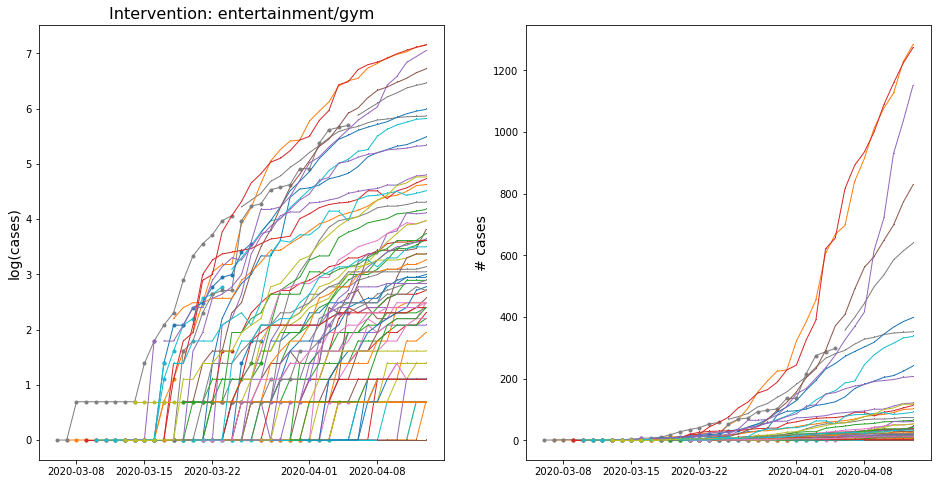

/home/lgai/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


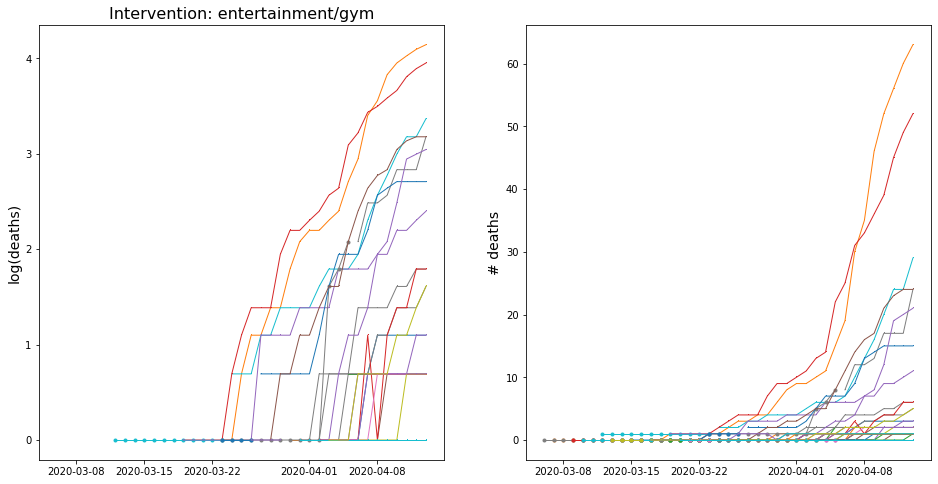

In [4]:
## plot counts over time for a few counties, before and after intervention
# changed marker after social distancing, could also put marker at social distance pt or something

def plot_counts_before_after(counts_df, count_name, intervention, fig_size=(16,8)):
    # x is ordinal date, for plotting
    x = matplotlib.dates.date2num(counts_df.columns[counts_mask])

    # ys is count in each county (row) and day (col)
    ys = counts_df.iloc[:,counts_mask]

    fig, axs = plt.subplots(1, 2, sharex=True, sharey=False, figsize=fig_size)

    axs[0].set_title('Intervention: %s' % intervention, size=16)
    axs[0].set_ylabel('log(%s)' % count_name, size=14)
    axs[1].set_ylabel('# %s' % count_name, size=14)

    for i in range(0,len(ys),30): # subset here to avoid messing up order of fips
        cond = x < counts_df[intervention][i] # is x before the cutoff date
        x_before = np.copy(x); x_before[~cond] = np.nan
        x_after = np.copy(x); x_after[cond] = np.nan
        # log(y)
        p = axs[0].plot_date(x_before, np.log(ys.iloc[i]),  marker='.',linewidth=1, linestyle='-')
        color = p[0].get_color() # want color to match for each county across plots
        axs[0].plot_date(x_after, np.log(ys.iloc[i]),  color=color, marker=',',linewidth=1, linestyle='-')
        # y
        axs[1].plot_date(x_before, ys.iloc[i], color=color,  marker='.',linewidth=1, linestyle='-')
        axs[1].plot_date(x_after, ys.iloc[i], color=color, marker=',',linewidth=1, linestyle='-')

    plt.show()
    return


plot_counts_before_after(cases_df, 'cases', intervention = 'entertainment/gym')
plot_counts_before_after(deaths_df, 'deaths', intervention = 'entertainment/gym')

# TODO in current plot, wouldn't obvious if a county never intervened (vs they intervened when cases still at 0)
# TODO could plot large counties only


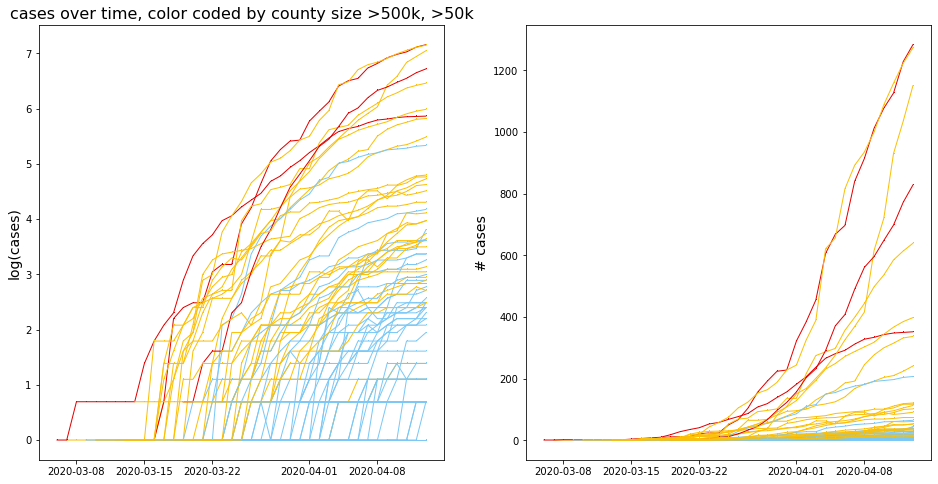

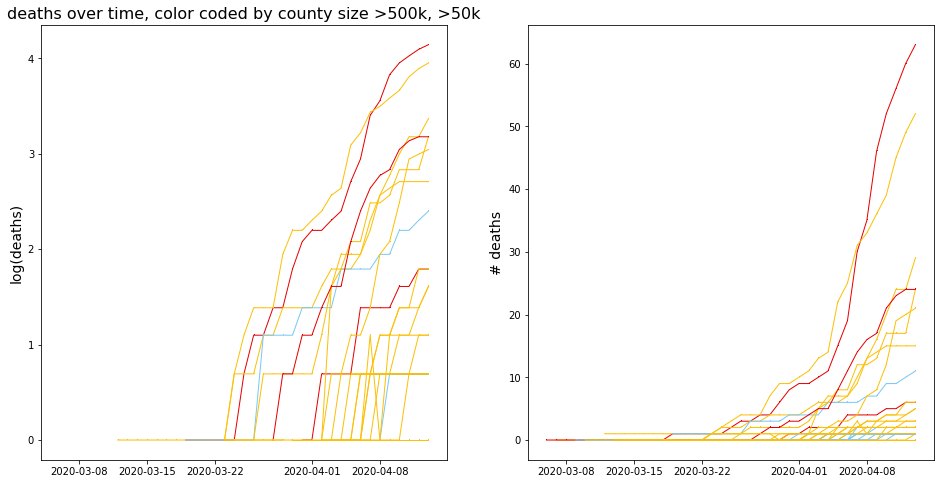

In [5]:
## plot counts for a few counties, color-code by condition
# current condition: pop size > 

def plot_counts_condition(counts_df, count_name, fig_size=(16,8)):
    '''currently plots for 3 bins of county size'''
    
    # x is ordinal date, for plotting
    x = matplotlib.dates.date2num(counts_df.columns[counts_mask])

    # ys is count in each county (row) and day (col)
    ys = counts_df.iloc[:,counts_mask]

    fig, axs = plt.subplots(1, 2, sharex=True, sharey=False, figsize=fig_size)

    axs[0].set_title('%s over time, color coded by county size >500k, >50k' % count_name, size=16)
    axs[0].set_ylabel('log(%s)' % count_name, size=14)
    axs[1].set_ylabel('# %s' % count_name, size=14)

    color_opt = ['xkcd:lightblue','xkcd:marigold', 'xkcd:red']

    for i in range(0,len(ys),30): # subset here to avoid messing up order of fips

        # condition
        j = int(counts_df['POP_ESTIMATE_2018'][i] > 5e4) + int(counts_df['POP_ESTIMATE_2018'][i] > 5e5)
        
        axs[0].plot_date(x, np.log(ys.iloc[i]), color=color_opt[j], marker=',',linewidth=1, linestyle='-') # log(y)
        axs[1].plot_date(x, ys.iloc[i], color=color_opt[j], marker=',', linewidth=1, linestyle='-')
        
    plt.show()
    return


plot_counts_condition(cases_df, 'cases')
plot_counts_condition(deaths_df, 'deaths')


# TODO args to pass in color after applying condition
# and/or continuous range of color, legend


>50 gatherings


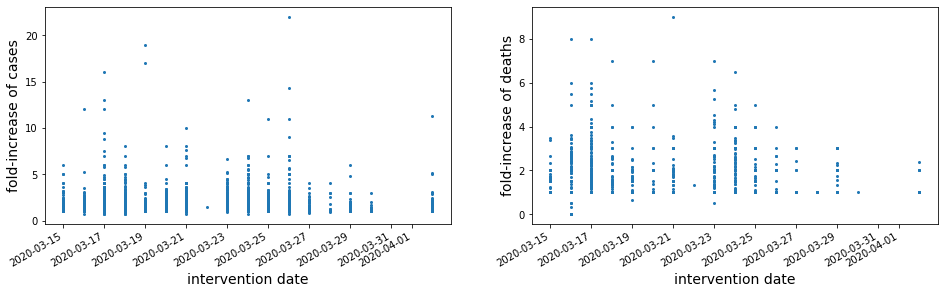

>500 gatherings


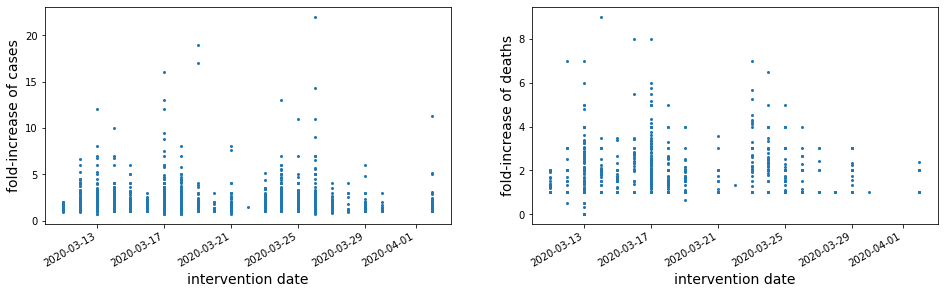

public schools


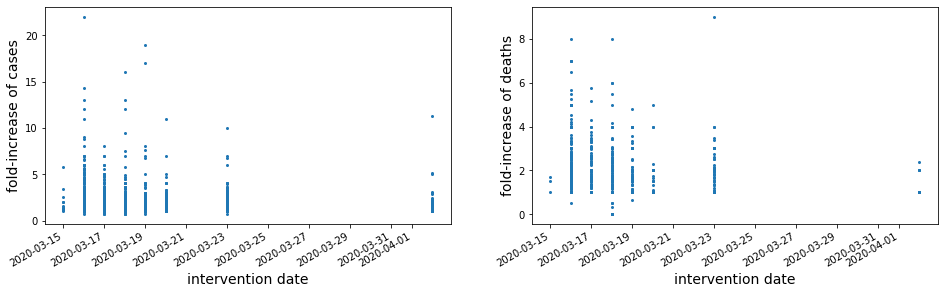

restaurant dine-in


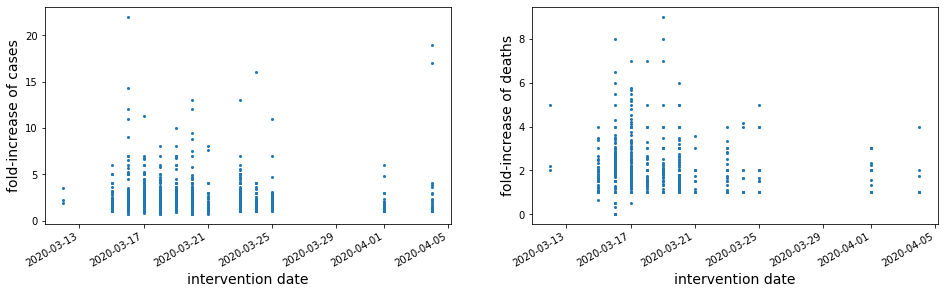

entertainment/gym


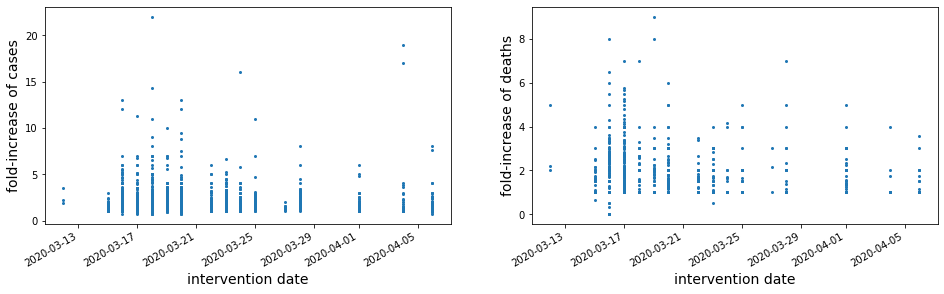

In [6]:
## plot date of intervention vs increase in the last week

for intervention in interventions_df.columns[4:-2]:
    print(intervention)

    fig, axs = plt.subplots(1,2,figsize=(16,4))
    
    cases_i = cases_df[pd.Timestamp(dt.date(2020,4,6))]
    cases_j = cases_df[pd.Timestamp(dt.date(2020,4,13))]
    y_fold_increase = 1.0*cases_j/cases_i

    intervention_dates = cases_df[intervention]
    axs[0].plot_date(intervention_dates, y_fold_increase, markersize=2)
    axs[0].set_xlabel('intervention date', size = 14)
    axs[0].set_ylabel('fold-increase of cases', size=14)

    
    deaths_i = deaths_df[pd.Timestamp(dt.date(2020,4,6))] # could automatically get last week from colname
    deaths_j = deaths_df[pd.Timestamp(dt.date(2020,4,13))]
    y_fold_increase = 1.0*deaths_j/deaths_i
    
    intervention_dates = deaths_df[intervention]
    axs[1].plot_date(intervention_dates, y_fold_increase, markersize=2)
    axs[1].set_xlabel('intervention date', size=14)
    axs[1].set_ylabel('fold-increase of deaths', size=14)

    plt.setp(axs[0].get_xticklabels(), rotation=30, horizontalalignment='right')
    plt.setp(axs[1].get_xticklabels(), rotation=30, horizontalalignment='right')

    plt.show()




In [45]:
# measure correlation between count on last day and demographics/intervention features

def printTopValues(values, columns, nTop=5, includeBottom=False, maxPad=80):
    '''given values and corresponding descriptions in order, print top values'''
    col_valuesL = list( zip(list(columns), values.flatten().tolist()) )
    col_valuesL.sort(key=lambda tup: abs(tup[1]), reverse=True)

    p = max( [len(str(c)) for c in columns] ) + 1 # padding for print
    p = min(p, maxPad)
    if nTop == None: # print all by default
        nTop = len(columns)
    for col, effect in col_valuesL[:nTop]:
        print('%s\t%10.5f' % ((str(col).ljust(p), effect)) )
    if includeBottom and nTop*2 > len(columns): 
        # print remaining entries without duplicates
        for col, effect in col_valuesL[nTop:]:
            print('%s\t%10.5f' % ((str(col).ljust(p), effect)) )
    elif includeBottom:
        print('...')
        for col, effect in col_valuesL[-nTop:]:
            print('%s\t%10.5f' % ((str(col).ljust(p), effect)) )        
    return


# raw counts of cases
corrs = cases_df.corr()[cases_df.columns[-1]] # returns a series
# need a new mask since corrs excludes state and county columns
corr_counts_mask = np.array([str(c)[:5] == '2020-' for c in corrs.index])
corrs = corrs[~corr_counts_mask]

print('*Correlation between # cases on last day and other non-count features*')
printTopValues(corrs.values, corrs.index, nTop=10)


# raw counts of deaths
corrs = deaths_df.corr()[deaths_df.columns[-1]] # returns a series
corrs = corrs[~corr_counts_mask]

print('\n\n*Correlation with # deaths on last day*')
printTopValues(corrs.values, corrs.index, nTop=10)



# fold increase of cases in last week 
cases_i = cases_df[pd.Timestamp(dt.date(2020,4,6))]
cases_j = cases_df[pd.Timestamp(dt.date(2020,4,13))]
raw_increase = 1.0*deaths_j/deaths_i
corrs = cases_df.corrwith(raw_increase)
print('\n\n*Correlation with fold-increase in last week*')
printTopValues(corrs.values, corrs.index, nTop=10)


print('\n\n(mostly divide by zero for fold increase in deaths, omitted for now)')

*Correlation between # cases on last day and other non-count features*
Endocrinology Diabetes and Metabolism specialists (2019)                        	   0.66175
Oncology (Cancer) specialists (2019)                                            	   0.65117
Internal Medicine Primary Care (2019)                                           	   0.64890
Cardiovascular Disease (AAMC)                                                   	   0.64767
Cardiology specialists (2019)                                                   	   0.64761
Physical Medicine & Rehabilitation (AAMC)                                       	   0.64670
Geriatric Medicine*** (AAMC)                                                    	   0.63680
Endocrinology Diabetes & Metabolism (AAMC)                                      	   0.62962
Infectious Disease (AAMC)                                                       	   0.62716
Psychiatry specialists (2019)                                                   	   0.62238


*Correl